# Filter analysis of Convolutional Layers

This notebook shows for each Convolutional Layer from a ConvNet trained to classify EEG data into classes of 4 different movements (right hand, left hand, idle, right foot) the on average most active filter.  
Inputs were run through the network and for each filter the 30 inputs which invoked maximum activation for that filter were saved. From those several types of different features are extracted and the distribution of those features is compared to a baseline of randomly sampled control inputs (also belonging to one of the 4 classes.  
The goal is to be able to investigate which features were learned by the different filters.

In [1]:
import numpy as np
import scipy

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import receptive_field
import analysis
import utils

In [4]:
max_baseline_inputs = 1000

In [5]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'
RF_save = receptive_field.ReceptiveFieldInputsIO()

In [6]:
rng = RandomState(98787)

In [7]:
def extract_features_and_diff(X_class,X_baseline,sampling_rate):
    features_class,features_base,feature_labels = extract_features(X_class,X_baseline,sampling_rate)
    
    feat_means = np.mean(features_class,axis=0)
    feat_means_base = np.mean(features_base,axis=0)
    feat_stds = np.std(features_class,axis=0)
    #feat_mean_diff = np.abs(np.divide(feat_means_base-feat_means,feat_stds_base))
    feat_mean_diff = np.abs(np.divide(feat_means-feat_means_base,feat_stds))
    # dirty hack to get rid of corrupted values
    # Investigate standard deviations of 0 !!!!!!!
    #feat_mean_diff[feat_mean_diff>10000000] = 0
    #feat_mean_diff = np.abs(np.divide(np.divide(feat_means-feat_means_base,feat_stds),feat_stds_base))

    return feat_mean_diff,feature_labels,features_class,features_base

def extract_features(X_class,X_baseline,sampling_rate):
    feature_funcs = (analysis.get_frequency,analysis.get_frequency_change,analysis.get_offset,analysis.get_offset_change)

    FFT,FFTc,mean,meanc = utils.get_feature_vals(X_class,feature_funcs,sampling_rate=sampling_rate)
    FFT_base,FFTc_base,mean_base,meanc_base = utils.get_feature_vals(X_baseline,feature_funcs,sampling_rate=sampling_rate)
    
    phase = np.angle(FFT)[:,1:]
    phasec = np.angle(FFTc)[:,1:]
    phase_base = np.angle(FFT_base)[:,1:]
    phasec_base = np.angle(FFTc_base)[:,1:]
    
    FFT = analysis.real_frequency(FFT)
    FFTc = analysis.real_frequency(FFTc)
    FFT_base = analysis.real_frequency(FFT_base)
    FFTc_base = analysis.real_frequency(FFTc_base)
    
    label_FFT = utils.create_feature_index_labels('FFT',FFT.shape[1:])
    label_FFTc = utils.create_feature_index_labels('FFTc',FFTc.shape[1:])
    label_phase = utils.create_feature_index_labels('Phase',phase.shape[1:])
    label_phasec = utils.create_feature_index_labels('Phasec',phasec.shape[1:])
    label_mean = utils.create_feature_index_labels('Mean',mean.shape[1:])
    label_meanc = utils.create_feature_index_labels('Meanc',meanc.shape[1:])
    
    features_class = utils.create_flattened_featurearr([FFT,FFTc,phase,phasec,mean,meanc],shape=(FFT.shape[0],-1))
    features_base = utils.create_flattened_featurearr([FFT_base,FFTc_base,phase_base,phasec_base,mean_base,meanc_base],shape=(FFT_base.shape[0],-1))
    feature_labels = utils.create_flattened_featurearr([label_FFT,label_FFTc,label_phase,label_phasec,label_mean,label_meanc])
    
    return features_class,features_base,feature_labels

In [8]:
def cut_input_data(RF_data,filt,separated_channels=True):
    reshape_channels = n_chans
    if separated_channels:
        reshape_channels = 1
    
    X_RF_cropped = utils.get_cropped_RF(RF_data.results[cl].RF_X,([0],[1],reshape_channels,-1))[filt]
    window_indeces = np.unique(RF_data.results[cl].max_units_in_filters[filt][:,2])
    
    inputs_baseline = RF_data.results[cl].inputs
    X_baseline = utils.cut_ind_windows(inputs_baseline,X_RF_cropped.shape[2],window_indeces).squeeze()
    X_baseline = X_baseline.reshape((-1,X_RF_cropped.shape[1],X_RF_cropped.shape[2]))[:1000]
    np.random.shuffle(X_baseline)
    X_baseline = X_baseline[:max_baseline_inputs]
    
    return X_RF_cropped,X_baseline 
    

def plot_max_filters(RF_data):
    print 'Max filters: ',RF_data.results[cl].max_filters
    plt.figure()
    plt.pcolor(np.reshape(RF_data.results[cl].filters_means,(-1,1)).T)
    plt.colorbar()
    plt.title('Mean activation for feature maps over all inputs')
    plt.show()
    
    
def print_features(score,labels,indeces):
    for idx in indeces:
        print '%f: %s'%(score[idx],labels[idx])
        
        
def plot_RF_starts(RF_data):
    plt.figure()
    sns.distplot(RF_data.results[cl].max_units_in_filters[filt][:,2],bins=np.arange(0,RF_data.results[cl].inputs.shape[2],20),kde=False)
    plt.xlim([0,RF_data.results[cl].inputs.shape[2]])
    plt.title('Starting of the RF windows in complete input signal')
    plt.show()
    
    
def plot_channels(RF_data):
    plt.figure()
    sns.distplot(RF_data.results[cl].max_units_in_filters[filt][:,3],bins=np.arange(n_chans),kde=False)
    plt.xlim([0,n_chans])
    plt.title('Channels that provided maximized input')
    plt.show()
        
        
def plot_channel_avg(X_RF_cropped,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X_RF_cropped[:,channel])
    limits = plt.gca().get_ylim()
    plt.show()
    
def plot_dist_comparison(features,features_base,idx):
    sns.distplot(features[:,idx],label='Input')
    sns.distplot(features_base[:,idx],label='Baseline')
    plt.legend()
    plt.xlabel(labels[idx])
    plt.show()
    
    
def subplots_4_features(features,features_base,indeces):
    plt.figure()
    plt.subplot(221)
    plot_dist_comparison(features,features_base,indeces[0])
    plt.subplot(222)
    plot_dist_comparison(features,features_base,indeces[1])
    plt.subplot(223)
    plot_dist_comparison(features,features_base,indeces[2])
    plt.subplot(224)
    plot_dist_comparison(features,features_base,indeces[3])

# Layer 03

In [9]:
filt = 0
filename = 'Layer03_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_03 = RF_save.load(os.path.join(savepath,modelname,filename))

In [10]:
cl = 0
n_chans = RF_data_03.results[cl].n_chans
sampling_rate = RF_data_03.results[cl].sampling_rate
sensor_names = RF_data_03.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_03,filt,separated_channels=True)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies[1:],sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies,sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [19  5 22 17]


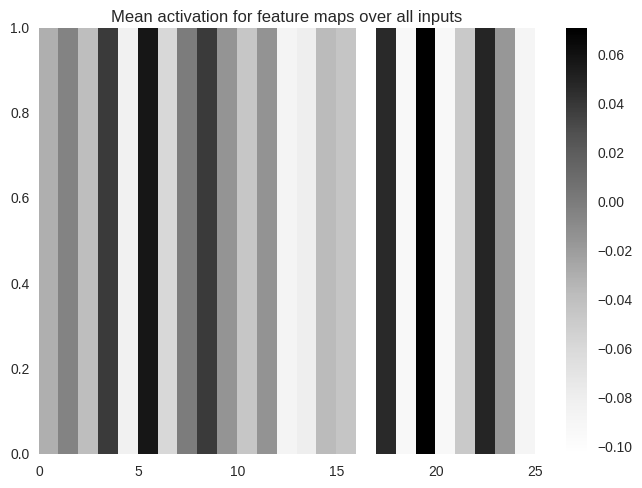

In [11]:
plot_max_filters(RF_data_03)

### Receptive field starting sample
Sample at which the receptive field started in the original input

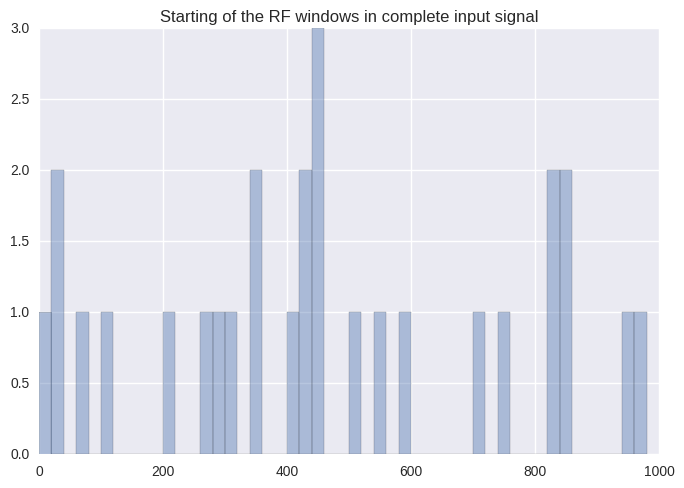

In [12]:
plot_RF_starts(RF_data_03)

### Channels of the Receptive Field
How often specific channels are contributing the highest activating input

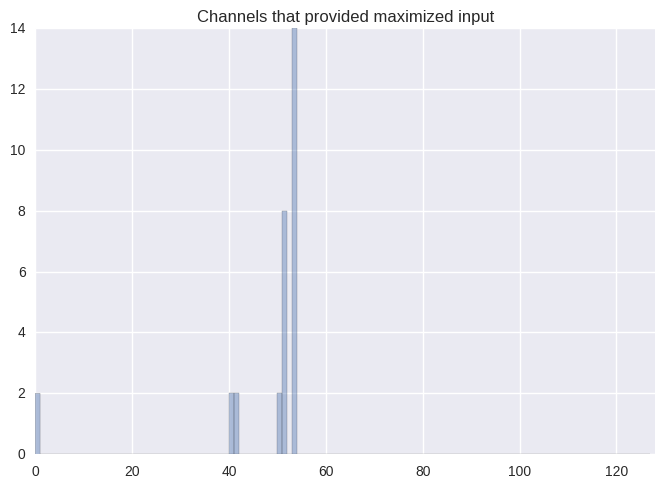

In [13]:
plot_channels(RF_data_03)

### Average input signal

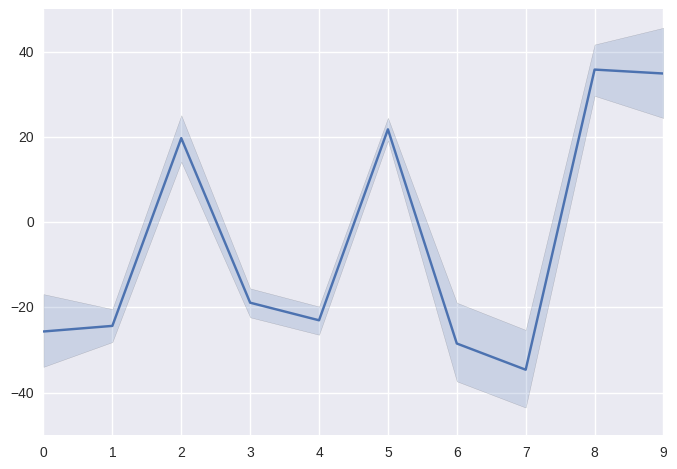

In [14]:
plot_channel_avg(X_RF_cropped,0)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [15]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

6.909211: FFT 75.0 Fp1
6.348906: FFT 100.0 Fp1
3.516302: FFTc 50.0 Fp1
2.401070: FFT 25.0 Fp1
2.168334: FFT 50.0 Fp1
1.726631: FFTc 25.0 Fp1
1.655815: Phasec 0.0 Fp1
0.965222: Meanc Fp1
0.726547: Phase 75.0 Fp1
0.570789: FFT 0.0 Fp1


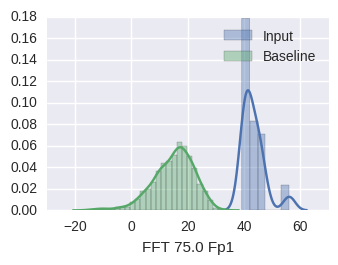

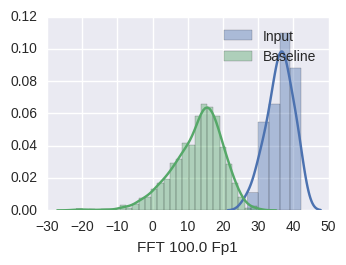

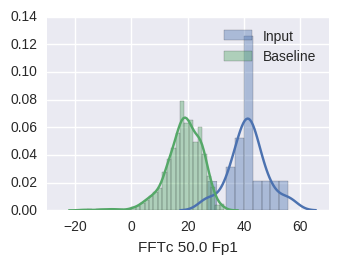

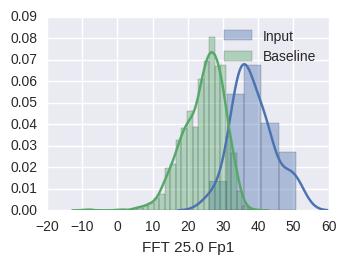

In [16]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

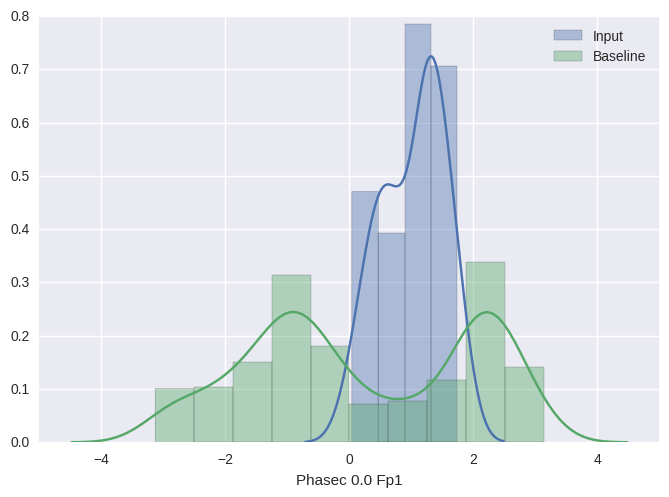

In [17]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[6])

# Layer 05

In [18]:
filt = 0
filename = 'Layer05_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_05 = RF_save.load(os.path.join(savepath,modelname,filename))

In [19]:
cl = 0
n_chans = RF_data_05.results[cl].n_chans
sampling_rate = RF_data_05.results[cl].sampling_rate
sensor_names = RF_data_05.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_05,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [14  8 19  5]


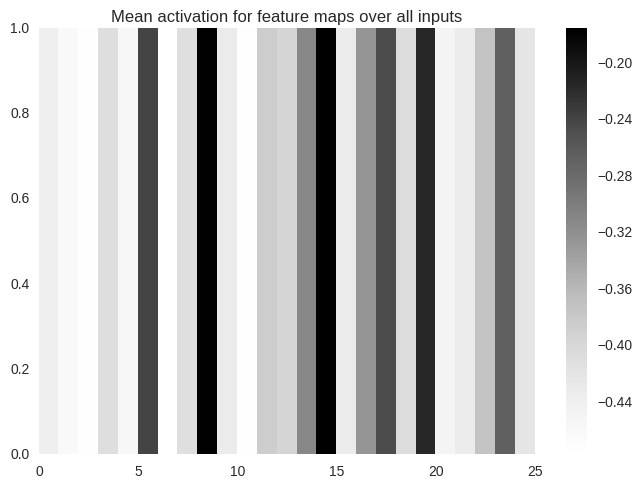

In [20]:
plot_max_filters(RF_data_05)

### Receptive field starting sample
Sample at which the receptive field started in the original input

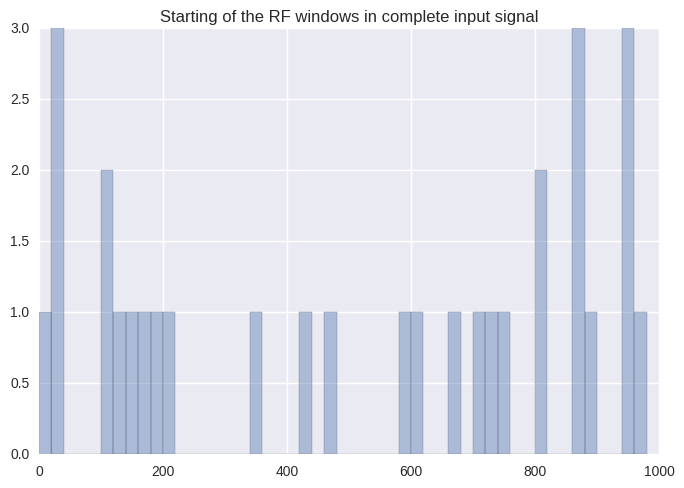

In [21]:
plot_RF_starts(RF_data_05)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [22]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

4.225970: Phase 75.0 CPP3h
4.218704: Phase 100.0 CPP5h
4.175742: FFT 50.0 C3
3.887628: Phase 100.0 FCC4h
3.673493: Phase 100.0 CPP3h
3.519507: Phase 25.0 P3
3.479735: Phase 25.0 CPP5h
3.419648: Phase 100.0 C4
3.391538: Phase 25.0 P5
3.351014: Phase 25.0 CCP3h


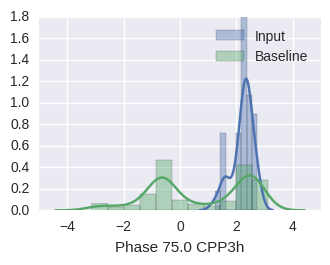

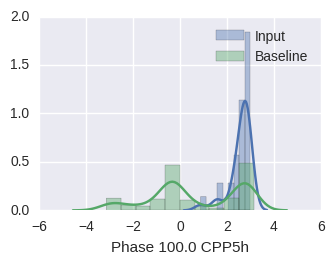

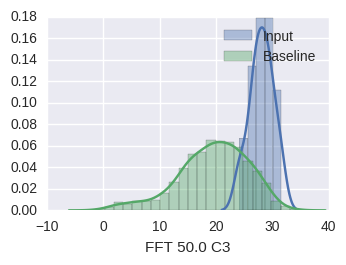

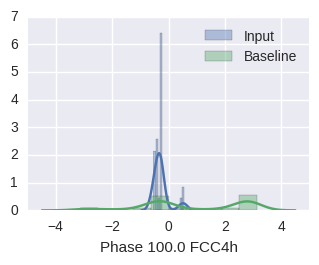

In [23]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

In [24]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [2, 83]] ['Phase', [3, 82]] ['FFT', [2, 55]] ['Phase', [3, 48]]
 ['Phase', [3, 83]] ['Phase', [0, 93]] ['Phase', [0, 82]]
 ['Phase', [3, 59]] ['Phase', [0, 92]] ['Phase', [0, 65]]]


### Average input signal

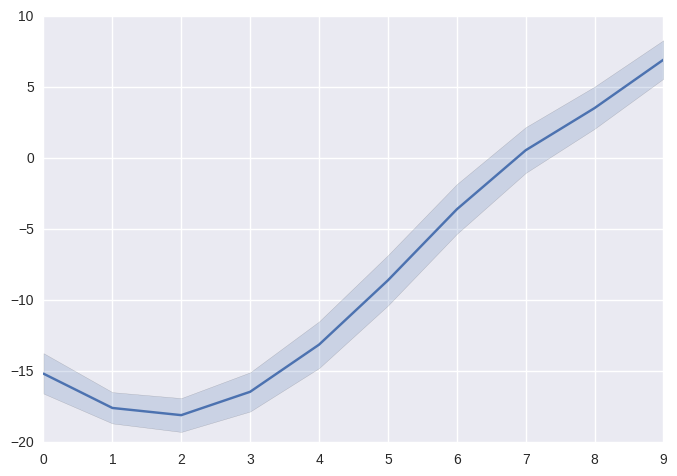

In [25]:
plot_channel_avg(X_RF_cropped,83)

# Layer 11

In [26]:
filename = 'Layer11_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_11 = RF_save.load(os.path.join(savepath,modelname,filename))

In [96]:
cl = 0
filt = 0
n_chans = RF_data_11.results[cl].n_chans
sampling_rate = RF_data_11.results[cl].sampling_rate
sensor_names = RF_data_11.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_11,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [13 31 19 41]


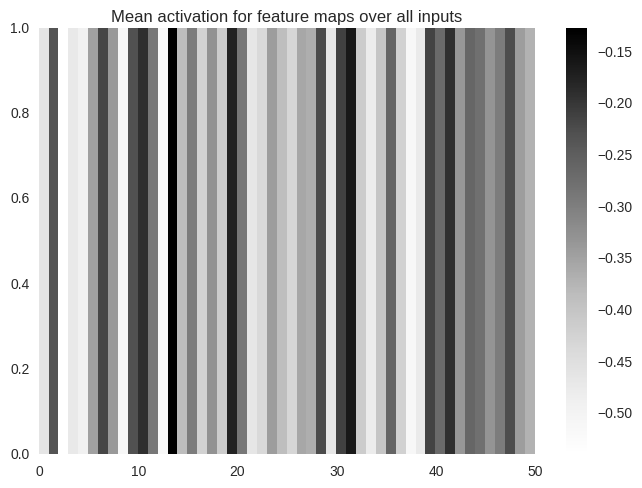

In [97]:
plot_max_filters(RF_data_11)

### Receptive field starting sample
Sample at which the receptive field started in the original input

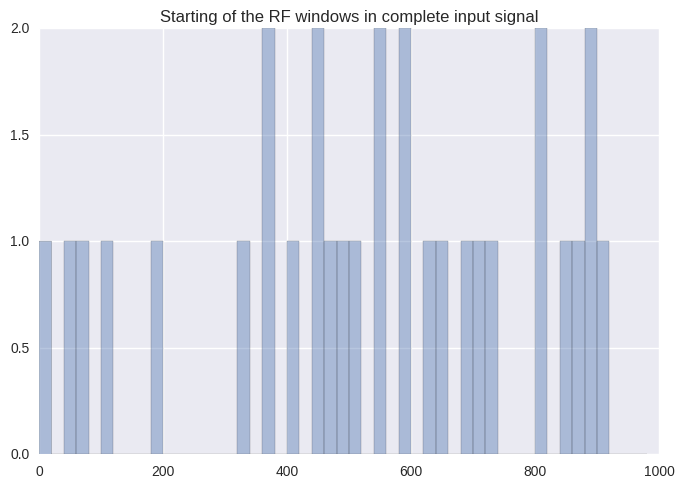

In [98]:
plot_RF_starts(RF_data_11)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [99]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

98.713020: Phase 115.384615385 CPP3h
70.473739: Phase 115.384615385 CP3
62.203517: Phase 115.384615385 CCP3h
34.783518: Phase 115.384615385 CP1
30.764704: Phase 115.384615385 C1
21.728105: Phase 108.974358974 CCP3h
15.057929: Phase 108.974358974 CP3
13.145041: Phase 108.974358974 CPP3h
12.552600: Phase 76.9230769231 CCP3h
10.191335: Phase 83.3333333333 CCP3h


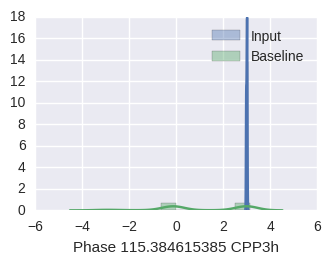

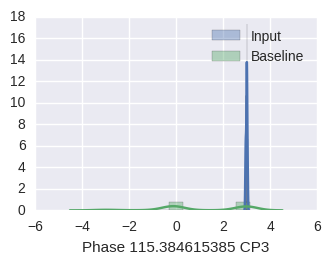

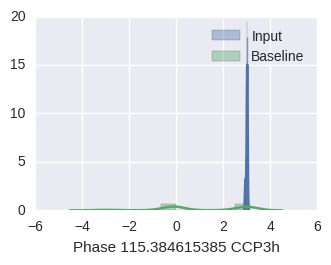

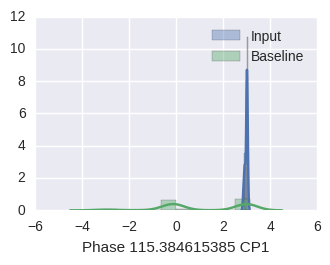

In [100]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

In [101]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [17, 83]] ['Phase', [17, 73]] ['Phase', [17, 65]]
 ['Phase', [17, 74]] ['Phase', [17, 56]] ['Phase', [16, 65]]
 ['Phase', [16, 73]] ['Phase', [16, 83]] ['Phase', [11, 65]]
 ['Phase', [12, 65]]]


### Average input signal

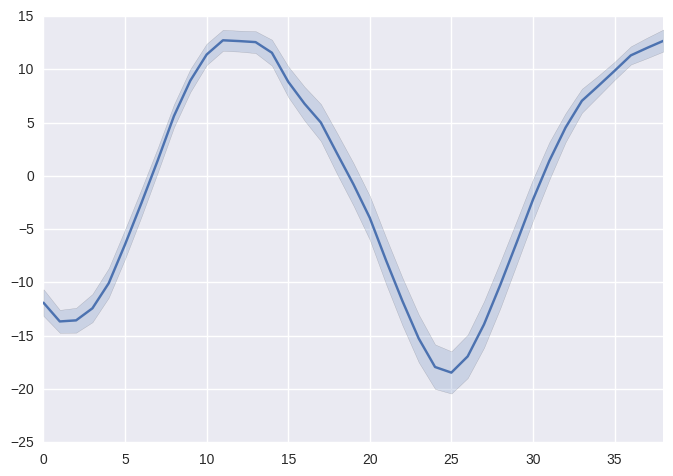

In [102]:
plot_channel_avg(X_RF_cropped,83)

# Layer 17

In [34]:
filt = 0
filename = 'Layer17_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_17 = RF_save.load(os.path.join(savepath,modelname,filename))

In [35]:
cl = 0
n_chans = RF_data_17.results[cl].n_chans
sampling_rate = RF_data_17.results[cl].sampling_rate
sensor_names = RF_data_17.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_17,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [76 88 55 95]


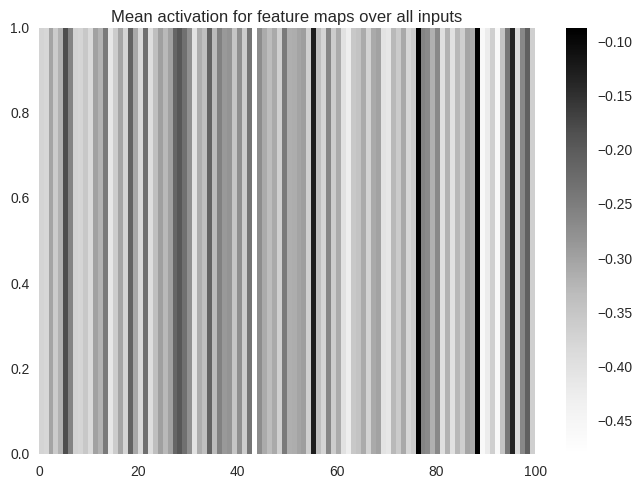

In [36]:
plot_max_filters(RF_data_17)

### Receptive field starting sample
Sample at which the receptive field started in the original input

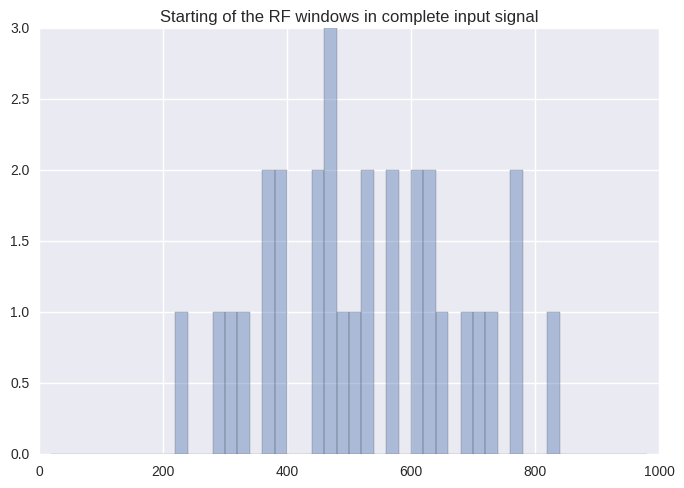

In [37]:
plot_RF_starts(RF_data_17)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [38]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

2.179018: Phasec 43.6507936508 CCP6h
1.886316: FFT 11.9047619048 C3
1.719836: Phase 9.92063492063 FFC5h
1.693320: Phase 69.4444444444 PO5
1.689446: Phase 69.4444444444 PPO5h
1.682517: Phase 9.92063492063 F5
1.656774: Phase 15.873015873 F5
1.642949: Mean FC2
1.625842: Mean FCC2h
1.618806: Mean Cz


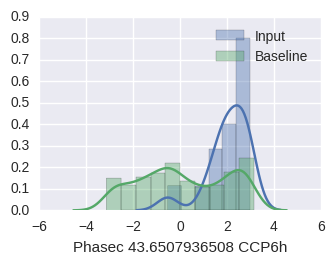

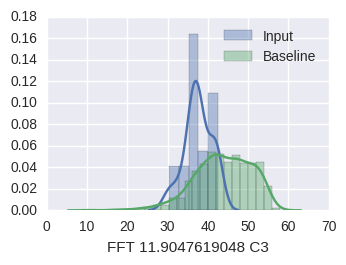

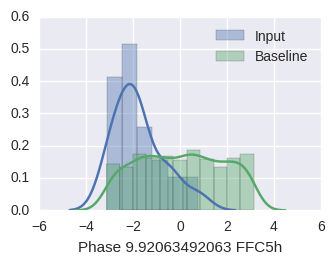

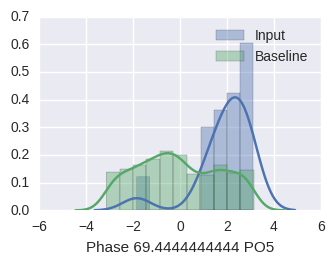

In [39]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

In [40]:
print index_labels[sort_mean_diff[:10]]

[['Phasec', [21, 69]] ['FFT', [6, 55]] ['Phase', [4, 24]]
 ['Phase', [34, 109]] ['Phase', [34, 102]] ['Phase', [4, 15]]
 ['Phase', [7, 15]] ['Mean', [37]] ['Mean', [47]] ['Mean', [57]]]


### Average input signal

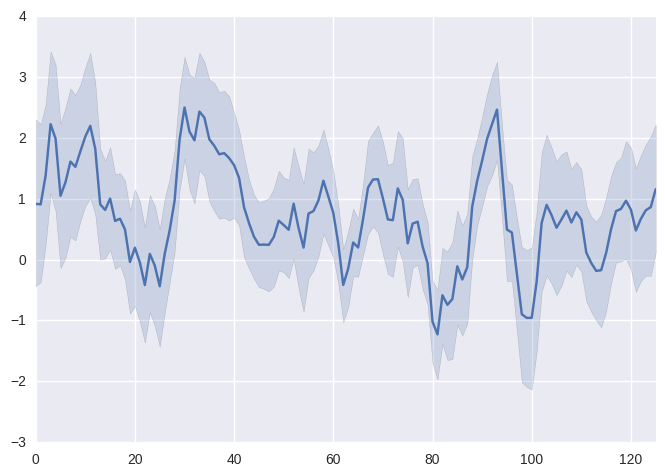

In [41]:
plot_channel_avg(X_RF_cropped,69)

# Layer 23

In [42]:
filt = 0
filename = 'Layer23_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_23 = RF_save.load(os.path.join(savepath,modelname,filename))

In [43]:
cl = 0
n_chans = RF_data_23.results[cl].n_chans
sampling_rate = RF_data_23.results[cl].sampling_rate
sensor_names = RF_data_23.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_23,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [193  50 156  21]


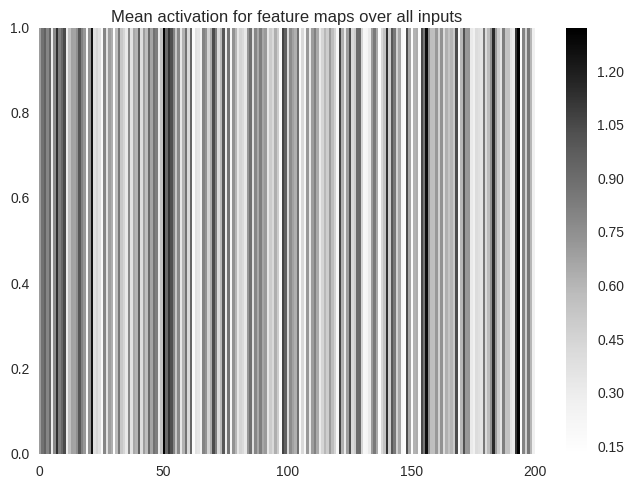

In [44]:
plot_max_filters(RF_data_23)

### Receptive field starting sample
Sample at which the receptive field started in the original input

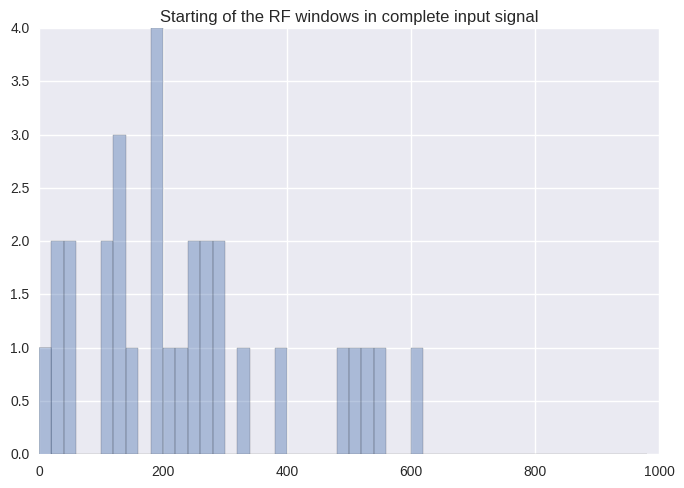

In [45]:
plot_RF_starts(RF_data_23)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [46]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

1.907786: Phasec 30.3617571059 CCP4h
1.864605: Phasec 11.6279069767 CCP4h
1.738148: Phasec 20.6718346253 AF7
1.715568: FFTc 3.87596899225 CP3
1.713164: Phasec 7.10594315245 CCP4h
1.615414: Phase 91.7312661499 AF8
1.606580: Phase 0.645994832041 P3
1.597337: FFTc 3.87596899225 CCP3h
1.592275: Phase 0.645994832041 AFz
1.569792: Phase 0.645994832041 CPP5h


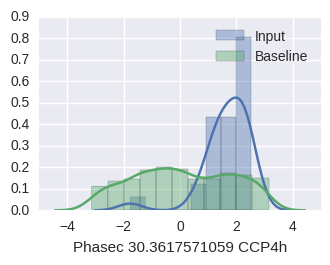

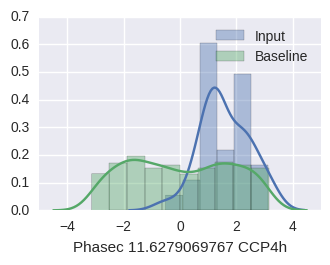

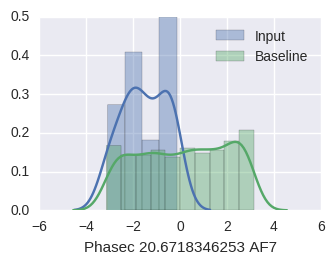

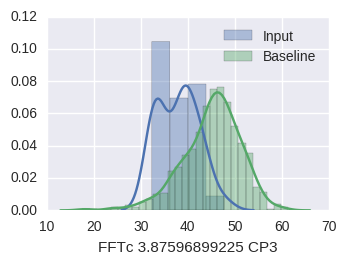

In [47]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

In [48]:
print index_labels[sort_mean_diff[:4]]

[['Phasec', [46, 68]] ['Phasec', [17, 68]] ['Phasec', [31, 5]]
 ['FFTc', [6, 73]]]


### Average input signal

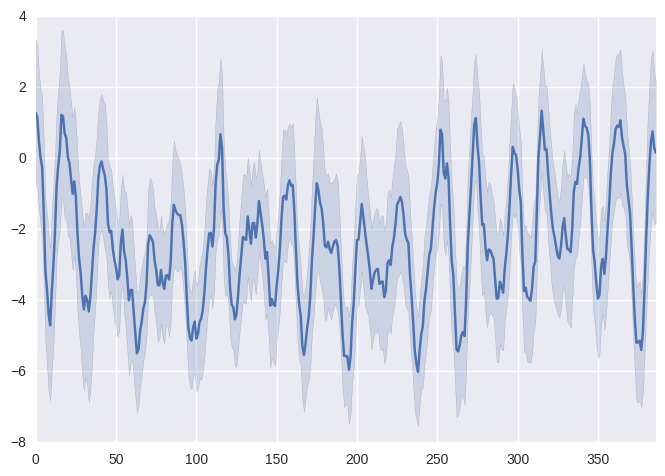

In [49]:
plot_channel_avg(X_RF_cropped,68)

# Layer 28

In [58]:
filename = 'Layer28_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_28 = RF_save.load(os.path.join(savepath,modelname,filename))

In [106]:
cl = 0
filt = 2
n_chans = RF_data_28.results[cl].n_chans
sampling_rate = RF_data_28.results[cl].sampling_rate
sensor_names = RF_data_28.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_28,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [1 2 0 3]


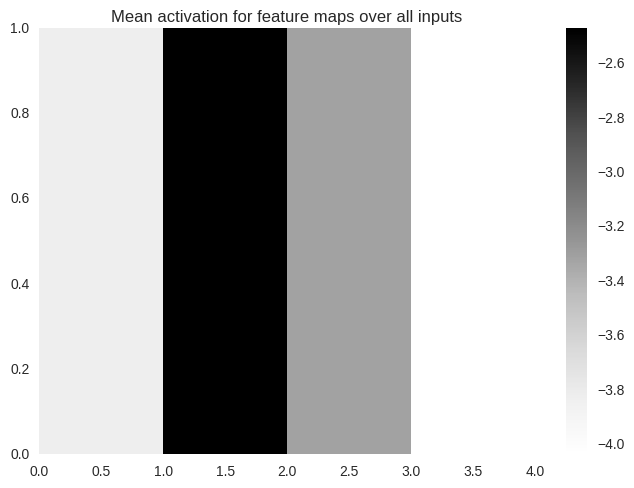

In [107]:
plot_max_filters(RF_data_28)

### Receptive field starting sample
Sample at which the receptive field started in the original input

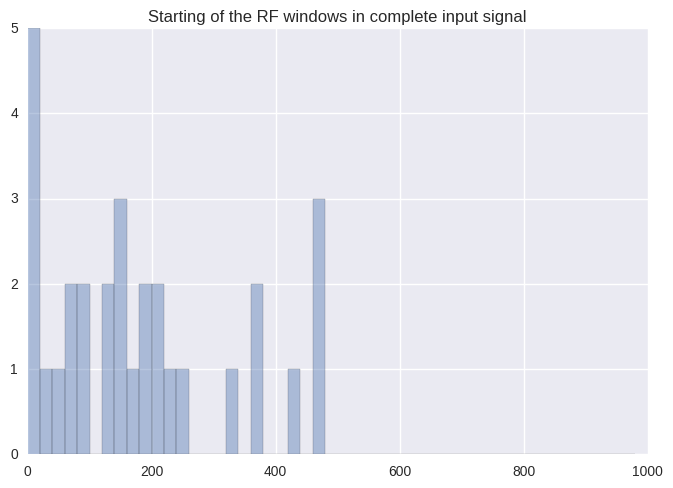

In [108]:
plot_RF_starts(RF_data_28)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [109]:
print_features(feat_mean_diff,labels,sort_mean_diff[:10])

2.263714: FFT 11.4942528736 C3
1.921632: Mean FC2
1.874409: Phase 50.2873563218 F7
1.833837: Mean FCC2h
1.739627: FFT 12.4521072797 CCP3h
1.697167: FFT 11.4942528736 CCP5h
1.630165: Mean Cz
1.569026: FFT 108.237547893 FCz
1.565491: FFT 11.4942528736 FCC3h
1.555213: FFTc 0.0 FCC2h


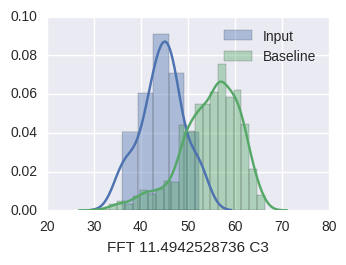

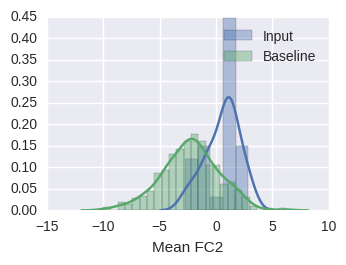

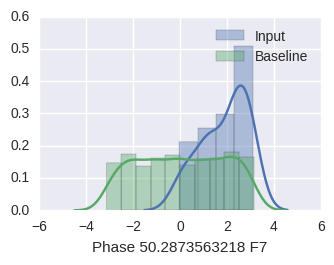

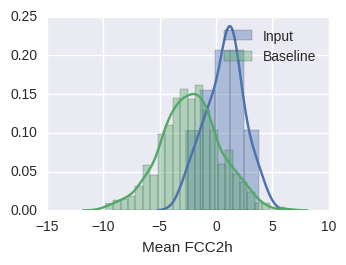

In [110]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

In [111]:
print index_labels[sort_mean_diff[:4]]

[['FFT', [24, 55]] ['Mean', [37]] ['Phase', [104, 14]] ['Mean', [47]]]


### Average input signal

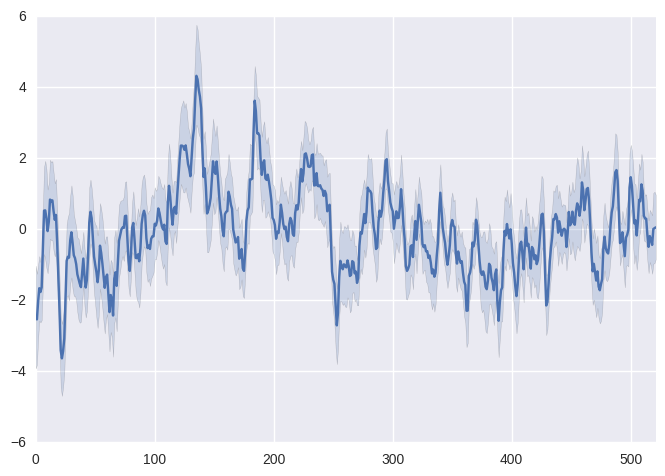

In [112]:
plot_channel_avg(X_RF_cropped,55)